In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from devito import *
from examples.seismic import Model, plot_velocity, demo_model
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
from examples.seismic import TimeAxis
from examples.seismic import Receiver
from examples.seismic import RickerSource
from devito import Operator
from matplotlib.animation import FuncAnimation


# plt.style.use("default")
mpl.rcParams.update(
    {
        'figure.constrained_layout.use': True,
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "font.size": 10,
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)

In [80]:

# ======================================================
# 1. Definir el modelo con una interfaz
# ======================================================
depth = 141   # profundidad total (m)
width = 141   # ancho del modelo (m)
shape = (depth, width)
v = np.empty(shape, dtype=np.float32)

# Definir velocidades
v1 = 1.0  # m/s (capa superior)
v2 = 3.5  # m/s (capa inferior)

# Definir profundidad de la interfaz (en celdas)
interface_depth = 20  # profundidad en número de celdas (60*spacing_z m)

# Asignar velocidades por capas
v[:, :interface_depth] = v1
v[:, interface_depth:] = v2

spacing_x = 0.5  # espaciamiento en x (m)
spacing_z = 0.5  # espaciamiento en z (m)

model = Model(
    origin=(0., 0.),
    shape=(width, depth),
    spacing=(spacing_x, spacing_z),
    nbl=100,
    nlayers=1,
    space_order=8,
    vp=v,
    bcs="damp",
)

# ======================================================
# 2. Fuente y receptores
# ======================================================
t0, tn = 0., 80.        # tiempo inicial y final (s)
dt = model.critical_dt    # paso de tiempo crítico
time_range = TimeAxis(start=t0, stop=tn, step=dt)

# Fuente Ricker
f0 = 0.30  # frecuencia central (Hz)
src = RickerSource(
    name='src', grid=model.grid, f0=f0,
    npoint=1, time_range=time_range
)

# Receptores: 101 separados uniformemente a lo largo del ancho
nreceivers = 12
rec = Receiver(
    name='rec', grid=model.grid,
    npoint=nreceivers, time_range=time_range
)

# Coordenadas de la fuente (centro horizontal, profundidad 20 m)
src.coordinates.data[0, :] = 5#np.array(model.domain_size) * 0.1
src.coordinates.data[0, -1] = 5.0

# Coordenadas de los receptores (superficie a 20 m de profundidad)
rec_coordinates = np.empty((nreceivers, 2))
rec.coordinates.data[:, 0] = np.arange(10,70,5)
rec.coordinates.data[:, 1] = 1.0

# ======================================================
# 3. Definir wavefield y PDE
# ======================================================
u = TimeFunction(
    name="u", grid=model.grid,
    time_order=2, space_order=8,
    save=time_range.num
)

# Inyección de fuente y lectura de receptores
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
rec_term = rec.interpolate(expr=u.forward)

# ======================================================
# 4. Visualizar modelo y geometría
# ======================================================
velocity_field = model.vp.data[
    tuple(slice(model.nbl, -model.nbl) for _ in range(2))
]
extent = [0, model.domain_size[0], model.domain_size[1], 0]

 
 
# PDE: m * u_tt - Δu + damp * u_t = 0
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))


# Finally we define the source injection and receiver read function to generate the corresponding code
src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)

# Create interpolation expression for receivers
rec_term = rec.interpolate(expr=u.forward)

# =====================
# 6. Ejecutar simulación
# =====================
 
op_fwd = Operator([stencil] + src_term + rec_term, subs=model.spacing_map)
op_fwd(dt=model.critical_dt)

# ======================================================
# Extract velocity field
# ======================================================
velocity_field = model.vp.data[
    tuple(slice(model.nbl, -model.nbl) for _ in range(2))
]
extent = [0, model.domain_size[0], model.domain_size[1], 0]

# ======================================================
# Extract wavefield at a given time instant
# ======================================================
idx_domain_ROI = (slice(None), slice(model.nbl, -model.nbl), slice(model.nbl, -model.nbl))
max_val = np.abs(u.data[idx_domain_ROI]).max()



Operator `initdamp` ran in 0.01 s
Operator `Kernel` ran in 0.08 s


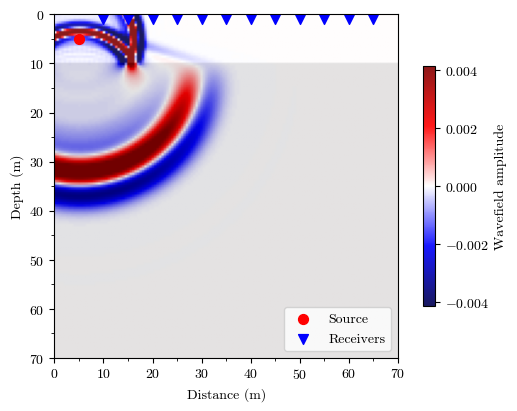

In [85]:

time_instant = 200  # frame index to plot
wavefield = u.data[idx_domain_ROI][time_instant, :, :].T

# ======================================================
# Plot combined figure
# ======================================================
plt.figure(figsize=(5, 4))

# Background: velocity model
plt.imshow(velocity_field.T, origin="upper", cmap="Greys", extent=extent)

# Overlay: wavefield with transparency
plt.imshow(wavefield, origin="upper", cmap="seismic",
           vmin=-max_val*0.05, vmax=max_val*0.05, extent=extent, alpha=0.9)

plt.colorbar(label="Wavefield amplitude", shrink=0.7)

# Source and receivers
plt.scatter(src.coordinates.data[:, 0], src.coordinates.data[:, 1],
            c="red", marker="o", s=50, label="Source")
plt.scatter(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1],
            c="blue", marker="v", s=50, label="Receivers")

# Axes configuration
ax = plt.gca()
ax.set_xticks(np.arange(0, model.domain_size[0]+10, 10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.set_yticks(np.arange(0, model.domain_size[1]+10, 10))
ax.yaxis.set_minor_locator(MultipleLocator(5))

plt.xlabel("Distance (m)")
plt.ylabel("Depth (m)")
plt.legend(loc="lower right")

plt.show()

In [60]:
# ==============================
# Output folder
# ==============================
output_dir = "refraction_data"
os.makedirs(output_dir, exist_ok=True)

# ==============================
# Extract simulation results
# ==============================
data = rec.data    
time = time_range.time_values 
receiver_positions = np.arange(10, 10 + 5*data.shape[1], 5)

# Normalize traces
data_norm = data / np.max(np.abs(data))

# ==============================
# Save in reusable format
# ==============================
np.savez(os.path.join(output_dir, "single_interface.npz"),
         seismograms=data_norm,
         time=time,
         receivers=receiver_positions)

# Also save CSV for easy inspection
np.savetxt(os.path.join(output_dir, "single_interface_seismograms.csv"), data_norm, delimiter=",")
np.savetxt(os.path.join(output_dir, "single_interface_time.csv"), time, delimiter=",")
np.savetxt(os.path.join(output_dir, "single_interface_receivers.csv"), receiver_positions, delimiter=",")


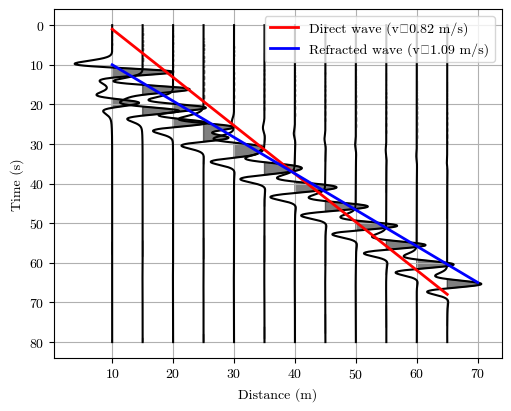

Direct wave slope = 1.2182 s/m, velocity = 0.82 m/s
Refracted wave slope = 0.9167 s/m, velocity = 1.09 m/s


In [103]:
# Normalización
data = data / np.max(np.abs(data))

plt.figure(figsize=(5, 4))
scale = 10
for i, xpos in enumerate(receiver_positions):
    trace = data[:, i]
    plt.plot(trace * scale + xpos, time, 'k')
    plt.fill_betweenx(time, xpos, trace * scale + xpos,
                      where=trace > 0, color='k', alpha=0.5)

# ==============================
# Línea directa (capa superior)
# ==============================
x1, t1 = 10, 1.0
x2, t2 = 65, 68.0

m1 = (t2 - t1) / (x2 - x1)
v1_app = 1 / m1

plt.plot([x1, x2], [t1, t2], 'r-', linewidth=2, label=f"Direct wave (v≈{v1_app:.2f} m/s)")

# ==============================
# Línea refractada (capa inferior)
# ==============================
x3, t3 = 10, 10.0   # ajusta este punto según tu gráfico
x4, t4 = 70, 65.0

m2 = (t4 - t3) / (x4 - x3)
v2_app = 1 / m2

plt.plot([x3, x4], [t3, t4], 'b-', linewidth=2, label=f"Refracted wave (v≈{v2_app:.2f} m/s)")

# ==============================
# Configuración de gráfico
# ==============================
plt.gca().invert_yaxis()
plt.xlabel("Distance (m)")
plt.ylabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Direct wave slope = {m1:.4f} s/m, velocity = {v1_app:.2f} m/s")
print(f"Refracted wave slope = {m2:.4f} s/m, velocity = {v2_app:.2f} m/s")

In [87]:
 
# ===================================
# Crear figura y ejes
# ===================================
fig, ax = plt.subplots(figsize=(5, 4))

# Fondo: campo de velocidades (solo una vez)
im_vel = ax.imshow(velocity_field.T, origin="upper", cmap="Greys",
                   extent=extent, vmin=3.0, vmax=4.0)

# Campo de onda (inicialmente vacío, se actualizará)
im_wave = ax.imshow(u.data[idx_domain_ROI][0, :, :].T, origin="upper", cmap="seismic",
                    vmin=-max_val*0.05, vmax=max_val*0.05, extent=extent, alpha=0.9)

# Fuente y receptores
ax.scatter(src.coordinates.data[:, 0], src.coordinates.data[:, 1],
           c="red", marker="o", s=50, label="Source")
ax.scatter(rec.coordinates.data[:, 0], rec.coordinates.data[:, 1],
           c="blue", marker="v", s=50, label="Receivers")

# Configuración de ejes
ax.set_xticks(np.arange(0, model.domain_size[0] + 10, 10))
ax.xaxis.set_minor_locator(MultipleLocator(50))
ax.set_yticks(np.arange(0, model.domain_size[1] + 10, 10))
ax.yaxis.set_minor_locator(MultipleLocator(50))

ax.set_xlabel("Distance (m)")
ax.set_ylabel("Depth (m)")
ax.legend(loc="lower right")

# ===================================
# Función de actualización
# ===================================
def update(frame):
    wavefield = u.data[idx_domain_ROI][frame, :, :].T
    im_wave.set_data(wavefield)
    # ax.set_title(f"Wavefield at frame {frame}")  # opcional
    return [im_wave]

# ===================================
# Crear animación
# ===================================
nframes = u.data.shape[0]  # total frames
ani = FuncAnimation(fig, update, frames=nframes, interval=30, blit=True)

# Guardar como MP4 o GIF
#ani.save("wavefield_animation.mp4", writer="ffmpeg", dpi=150)
ani.save("refraction_data/single_interface.gif", writer="pillow", dpi=100)